# Predicting Likelihood of Purchasing a Vacation Home


### Import Required Packages

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Processing and Visualization Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
import time
from random import randrange
import scorecardpy as sc
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Machine Learning Classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Model Selection
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Display settings
sns.set(color_codes=True)
pd.options.display.max_columns = 20


# Data Exploration and Preprocessing
### Remove skeptical data
- Based on common sense or business judgement
- Variables correlation
- Data distribution
- Missing values
- Information value

### Data imputation
### Data structure preprocessing

- Split data into training and test
- Split data into samples(x) and labels(y)

Load the dataset from csv:

In [2]:
df = pd.read_csv("lv_data_liftcharted.csv")

In [3]:
print("There are", df.shape[0], "individuals and", df.shape[1], "variables in the dataset.")

There are 110022 individuals and 122 variables in the dataset.


In [59]:
df.columns

Index(['age', 'tax_amount', 'sale_price', 'household_age_range',
       'inf_presence_of_children', 'inf_length_of_residence',
       'merkle_marketing_rank', 'inf_cardholder_rank',
       'prob_opening_annuity_acct_in_12_mths', 'generic_risk_score',
       ...
       'reserv_oth_recordcount_index', 'y', 'htc_other_revenue_rank',
       'cnt_package_orl_ny_mb', 'cnt_tour_ny_orl', 'mega_marital_M',
       'mega_marital_S', 'dsf_residence_N', 'dsf_residence_NA',
       'dsf_residence_Y'],
      dtype='object', length=116)

In [ ]:
sns.distplot(df["avg_home_value"][df["y"]==0], kde=True, color="red")
sns.distplot(df["avg_home_value"][df["y"]==1], kde=True, color="green")
plt.show()

In [4]:
df = df[df["age"]!=18]

In [5]:
# drop those variables with no more than 1 unique value
to_drop = list(df.nunique()[df.nunique()==1].index)
df = df.drop(to_drop, axis = 1)

### Correlation of Variables
Taking first 40 variables as example

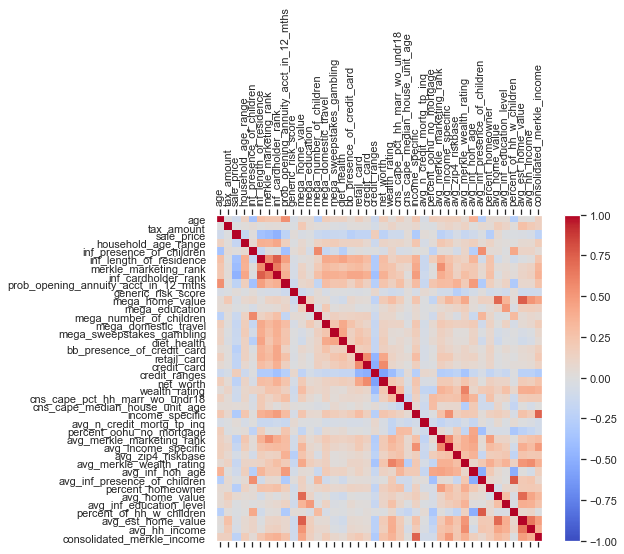

In [6]:
# correlation matrix
corr = df.iloc[:,0:40].corr()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.iloc[:,0:40].columns),1)
plt.xticks(rotation=90)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df.iloc[:,0:40].columns)
ax.set_yticklabels(df.iloc[:,0:40].columns)
ax.grid(False)
plt.show()

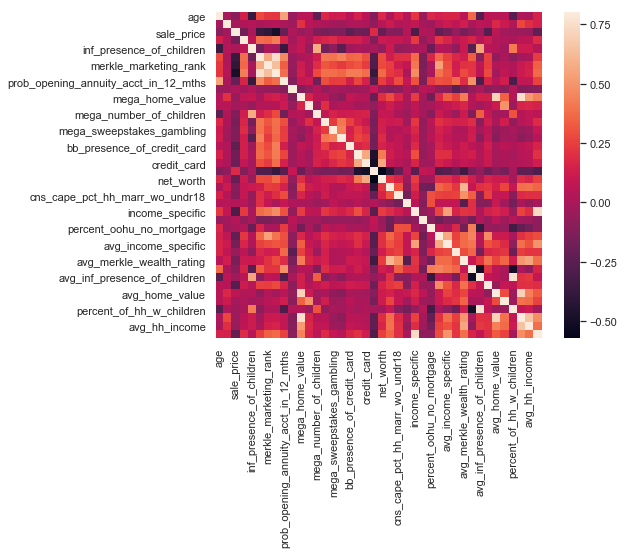

In [7]:
# alternative correlation matrix
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, vmax=0.8, square=True);

### Distribution Plots

C:\Users\Laura\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


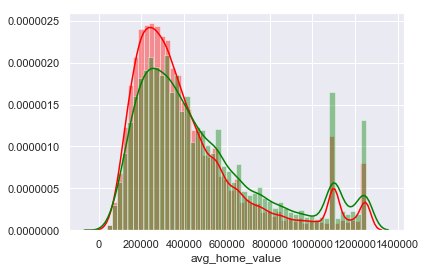

In [8]:
sns.distplot(df["avg_home_value"][df["y"]==0], kde=True, color="red")
sns.distplot(df["avg_home_value"][df["y"]==1], kde=True, color="green")
plt.show()
# those sudden spikes may arise from imputation

### Woe Binning and IV

In [9]:
# woe binning
bins = sc.woebin(df, y="y")

C:\Users\Laura\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Binning on 86033 rows and 116 columns in 00:00:48


In [10]:
print(bins["hawaii_distance"])
print(bins["avg_hh_income"])

          variable              bin  count  count_distr   good    bad  \
0  hawaii_distance    [-inf,3700.0)  23841     0.277115   6421  17420   
1  hawaii_distance  [3700.0,4300.0)  17512     0.203550  10230   7282   
2  hawaii_distance  [4300.0,4500.0)  10640     0.123673   7685   2955   
3  hawaii_distance     [4500.0,inf)  34040     0.395662  27463   6577   

    badprob       woe    bin_iv  total_iv  breaks  is_special_values  
0  0.730674  1.412197  0.543542  0.921449  3700.0              False  
1  0.415829  0.074233  0.001130  0.921449  4300.0              False  
2  0.277726 -0.541620  0.033604  0.921449  4500.0              False  
3  0.193214 -1.015109  0.343173  0.921449     inf              False  
        variable                  bin  count  count_distr   good    bad  \
0  avg_hh_income      [-inf,115000.0)  58772     0.683133  35015  23757   
1  avg_hh_income  [115000.0,135000.0)  10046     0.116769   6153   3893   
2  avg_hh_income  [135000.0,165000.0)   9433     0.109

{'pkg_records_index_mb': <Figure size 432x288 with 2 Axes>}

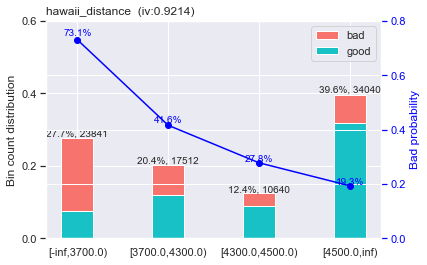

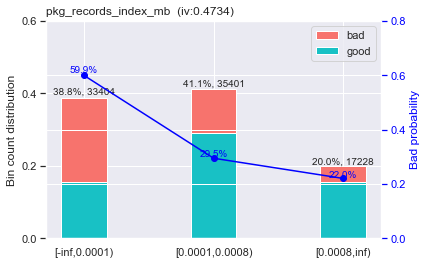

In [11]:
sc.woebin_plot(bins["hawaii_distance"] )
sc.woebin_plot(bins["pkg_records_index_mb"] )

In [12]:
iv_df = pd.DataFrame()
for i in list(iter(bins)):
    iv_df = iv_df.append(bins[i][["variable","total_iv"]].head(1))
iv_df = iv_df.sort_values(by=["total_iv"],ascending=False)

print(iv_df.head(10).to_string(index=False))

variable  total_iv
             hawaii_distance  0.921449
                 mb_distance  0.903870
                 lv_distance  0.860573
                 ny_distance  0.853531
            orlando_distance  0.827314
                 cnt_tour_lv  0.575010
reserv_oth_recordcount_index  0.574229
              cnt_package_lv  0.518313
        pkg_records_index_mb  0.473416
       pkg_records_index_orl  0.397181


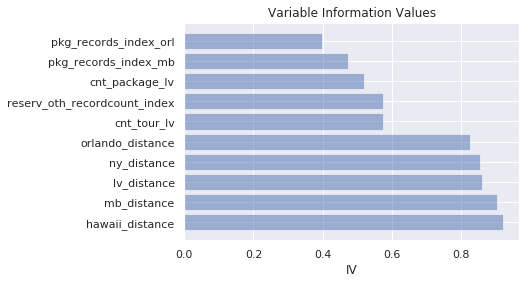

In [13]:
objects = (list(iv_df["variable"].head(10)))
y_pos = np.arange(len(objects))
performance = list(iv_df["total_iv"].head(10))
 
plt.subplot().barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('IV')
plt.title('Variable Information Values')
plt.style.use("default")
 
plt.show()

In [14]:
# sc.woebin_plot(bins)

In [15]:
# check distribution of the target variable as well as data types of the independent variables
print(df["y"].value_counts(normalize = False, dropna = False))
print(df.dtypes.value_counts())

0    51799
1    34234
Name: y, dtype: int64
int64      70
float64    46
dtype: int64


### Data Imputation
Replace all NA with mean values of the corresponding variables

In [16]:
df_new = df.fillna(df.mean())

### Split Data

In [17]:
# randomly split dataframe into train and test
msk = np.random.rand(len(df_new)) < 0.67
train = df_new[msk]
test = df_new[~msk]

In [18]:
x_train = train.drop("y", axis=1).values
y_train = train["y"].values
x_test = test.drop("y", axis=1).values
y_test = test["y"].values

In [19]:
# normalize the values of variables for optimizing the learning rate
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.fit_transform(x_test)

In [8]:
x_train

array([[1.81818182e-01, 5.75667505e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [6.96969697e-01, 6.54004349e-03, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.93939394e-01, 4.88883834e-03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [3.93939394e-01, 7.15128408e-04, 6.17012134e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.93939394e-01, 1.15715408e-02, 6.26102640e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [5.00000000e-01, 9.02129870e-03, 3.97888109e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

# Neural Network
1. Design the layer structure of model
2. Define parameters
3. Train the model
4. Make prediction on test

In [20]:
model = keras.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

In [21]:
# adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer="adam", 
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.5)

Train on 28890 samples, validate on 28891 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
28890/28890 [==============================] - 2s 52us/sample - loss: 0.5482 - binary_accuracy: 0.7267 - val_loss: 0.5192 - val_binary_accuracy: 0.7516
Epoch 2/5
28890/28890 [==============================] - 1s 46us/sample - loss: 0.5127 - binary_accuracy: 0.7550 - val_loss: 0.5171 - val_binary_accuracy: 0.7531
Epoch 3/5
28890/28890 [==============================] - 1s 46us/sample - loss: 0.5111 - binary_accuracy: 0.7559 - val_loss: 0.5148 - val_binary_accuracy: 0.7558
Epoch 4/5
28890/28890 [==============================] - 1s 46us/sample - loss: 0.5105 - binary_accuracy: 0.7564 - val_loss: 0.5159 - val_binary_accuracy: 0.7546
Epoch 5/5
28890/28890 [==============================] - 1s 46us/sample - loss: 0.5097 - binary_accuracy: 0.7575 - val_loss: 0.5174 - val_binary_accuracy: 0.7535


In [23]:
# print(history.history.keys())

28252/28252 [==============================] - 0s 16us/sample - loss: 0.5070 - binary_accuracy: 0.7576
Test accuracy: 0.7575747
0.8227775040868663


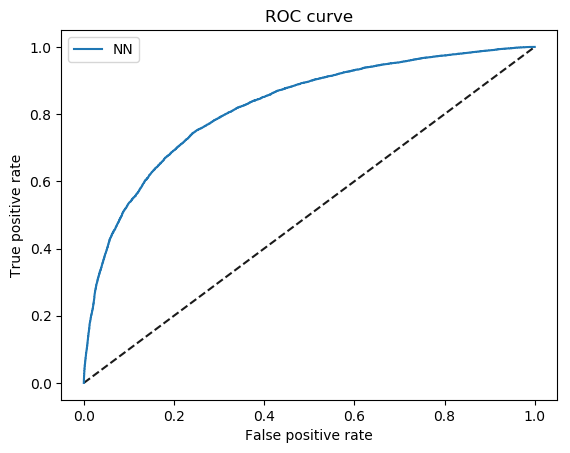

In [24]:
# Model evaluation
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

# Make predictions
predictions = model.predict(x_test)
y_pred_nn = model.predict_proba(x_test)[:,1]
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)
print(roc_auc_score(y_test, y_pred_nn))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nn, tpr_nn, label='NN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Benchmark
Compare the performance of different available ML packages in terms of scores and speed

In [26]:
max_depth = 10
n_estimator = 40
random_state = 110

In [30]:
# The logistic regression by itself
start = time. time()
lr = LogisticRegression(max_iter=500, solver='lbfgs',
                          random_state=random_state)
lr.fit(x_train, y_train)
acc_lr = accuracy_score(y_test, lr.predict(x_test))
y_pred_lr = lr.predict_proba(x_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_lr)
end = time. time()
time_lr = end - start
print (time_lr, "s")

5.2130351066589355 s


In [31]:
# The logistic regression by itself
start = time. time()
lr_sgd = SGDClassifier(max_iter=500, loss="log",
                          random_state=random_state)
lr_sgd.fit(x_train, y_train)
acc_lr_sgd = accuracy_score(y_test, lr_sgd.predict(x_test))
y_pred_lr_sgd = lr_sgd.predict_proba(x_test)[:, 1]
fpr_lr_sgd, tpr_lr_sgd, _ = roc_curve(y_test, y_pred_lr_sgd)
auc_lr_sgd = roc_auc_score(y_test, y_pred_lr_sgd)
end = time. time()
time_lr_sgd = end - start
print (time_lr_sgd, "s")

C:\Users\Laura\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


11.268982648849487 s


In [32]:
# The random forest model by itself
start = time. time()
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                          random_state=random_state)
rf.fit(x_train, y_train)
acc_rf = accuracy_score(y_test, rf.predict(x_test))
y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf)
end = time. time()
time_rf = end - start
print (time_rf, "s")

6.1238439083099365 s


In [33]:
# The gradient boosted model by itself
start = time. time()
grd = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimator,
                          random_state=random_state)
grd.fit(x_train, y_train)
acc_grd = accuracy_score(y_test, grd.predict(x_test))
y_pred_grd = grd.predict_proba(x_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
auc_grd = roc_auc_score(y_test, y_pred_grd)
end = time. time()
time_grd = end - start
print (time_grd, "s")

214.18537855148315 s


In [34]:
# The XGBoost model by itself
start = time. time()
xgb = XGBClassifier(max_depth=max_depth, n_estimators=n_estimator,
                          random_state=random_state, eta = 0.1)
xgb.fit(x_train,y_train)
acc_xgb = accuracy_score(y_test, xgb.predict(x_test))
y_pred_xgb = xgb.predict_proba(x_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
end = time. time()
time_xgb = end - start
print (time_xgb, "s")

36.70213603973389 s


In [35]:
# The XGBoost model by itself using histogram based algorithm
start = time. time()
xgb_h = XGBClassifier(max_depth=max_depth, n_estimators=n_estimator,
                          random_state=random_state, eta = 0.1, tree_method = "hist")
xgb_h.fit(x_train,y_train)
acc_xgb_h = accuracy_score(y_test, xgb_h.predict(x_test))
y_pred_xgb_h = xgb_h.predict_proba(x_test)[:, 1]
fpr_xgb_h, tpr_xgb_h, _ = roc_curve(y_test, y_pred_xgb_h)
auc_xgb_h = roc_auc_score(y_test, y_pred_xgb_h)
end = time. time()
time_xgb_h = end - start
print (time_xgb_h, "s")

21.962666273117065 s


In [36]:
# The LGBM model by itself
start = time. time()
lgb = LGBMClassifier(max_depth=max_depth, n_estimators=n_estimator,
                          random_state=random_state)
lgb.fit(x_train,y_train)
acc_lgb = accuracy_score(y_test, lgb.predict(x_test))
y_pred_lgb = lgb.predict_proba(x_test)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_lgb, drop_intermediate=False)
auc_lgb = roc_auc_score(y_test, y_pred_lgb)
# kfold = KFold(n_splits=5, random_state=7)
# results = cross_val_score(lgb, x_train, y_train, cv=kfold)
end = time. time()
time_lgb = end - start
print (time_lgb, "s")
# print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

3.035797119140625 s


In [37]:
# The CatBoost model by itself
start = time. time()
CB = CatBoostClassifier(max_depth=max_depth, n_estimators=n_estimator,
                          random_state=random_state, eta = 0.1, verbose=0)
CB.fit(x_train,y_train)
acc_CB = accuracy_score(y_test, CB.predict(x_test))
y_pred_CB = CB.predict_proba(x_test)[:, 1]
fpr_CB, tpr_CB, _ = roc_curve(y_test, y_pred_CB)
auc_CB = roc_auc_score(y_test, y_pred_CB)
end = time. time()
time_CB = end - start
print (time_CB, "s")
#########################################################

28.086512327194214 s


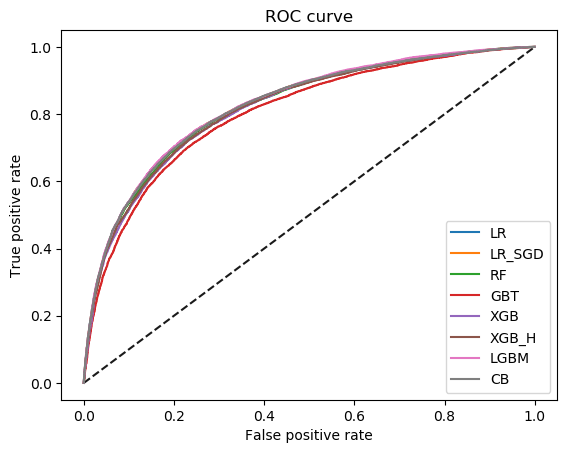

In [38]:
# plot ROC curves
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
# plt.plot(fpr_rf, tpr_rf, label='RF + LR')
# plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_lr_sgd, tpr_lr_sgd, label='LR_SGD')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.plot(fpr_xgb_h, tpr_xgb_h, label='XGB_H')
plt.plot(fpr_lgb, tpr_lgb, label='LGBM')
plt.plot(fpr_CB, tpr_CB, label='CB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

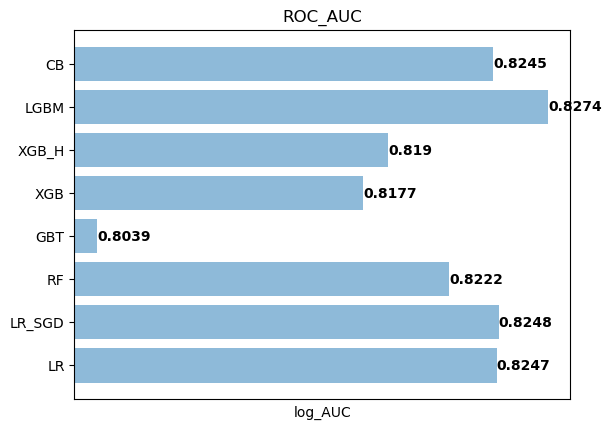

In [39]:
# compare AUC values
objects = ["LR", "LR_SGD", "RF", "GBT", "XGB", "XGB_H", "LGBM", "CB"]
y_pos = np.arange(len(objects))
y_auc = [auc_lr, auc_lr_sgd, auc_rf, auc_grd, auc_xgb, auc_xgb_h, auc_lgb, auc_CB]
y_auc = [round(elem, 4) for elem in y_auc]
 
plt.barh(y_pos, y_auc, align='center', alpha=0.5, log=True)
plt.yticks(y_pos, objects)
plt.xlabel('log_AUC')
plt.title('ROC_AUC')

for i, v in enumerate(y_auc):
    plt.text(v, i, str(v), va='center', color='black', fontweight='bold')
    
plt.show()

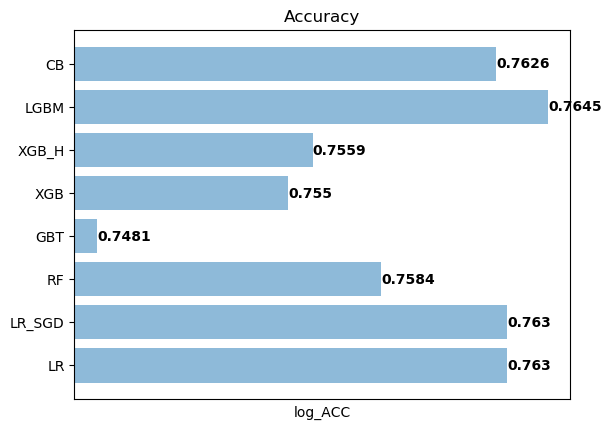

In [40]:
# compare accuracy values
objects = ["LR", "LR_SGD", "RF", "GBT", "XGB", "XGB_H", "LGBM", "CB"]
y_pos = np.arange(len(objects))
y_acc = [acc_lr, acc_lr_sgd, acc_rf, acc_grd, acc_xgb, acc_xgb_h, acc_lgb, acc_CB]
y_acc = [round(elem, 4) for elem in y_acc]
 
plt.barh(y_pos, y_acc, align='center', alpha=0.5, log=True)
plt.yticks(y_pos, objects)
plt.xlabel('log_ACC')
plt.title('Accuracy')

for i, v in enumerate(y_acc):
    plt.text(v, i, str(v), va='center', color='black', fontweight='bold')
    
plt.show()

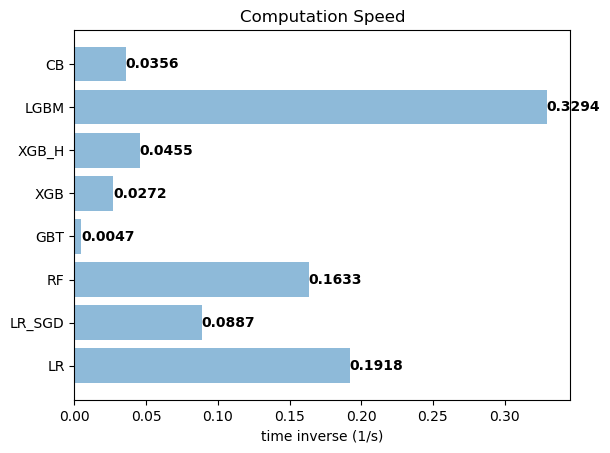

In [41]:
# compare time
objects = ["LR", "LR_SGD", "RF", "GBT", "XGB", "XGB_H", "LGBM", "CB"]
y_pos = np.arange(len(objects))
y_time = [1/time_lr, 1/time_lr_sgd, 1/time_rf, 1/time_grd, 1/time_xgb, 1/time_xgb_h, 1/time_lgb, 1/time_CB]
y_time = [round(elem, 4) for elem in y_time]
 
plt.barh(y_pos, y_time, align='center', alpha=0.5, log=False)
plt.yticks(y_pos, objects)
plt.xlabel('time inverse (1/s)')
plt.title('Computation Speed')

for i, v in enumerate(y_time):
    plt.text(v, i, str(v), va='center', color='black', fontweight='bold')
    
plt.show()

# Grid Search

In [137]:
# grid search
rf = RandomForestClassifier()
n_estimators = range(10, 120, 30)
max_depth = [14]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(rf, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[14]
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.4min finished


Best: 0.820317 using {'max_depth': 14, 'n_estimators': 100}
0.807111 (0.004214) with: {'max_depth': 14, 'n_estimators': 10}
0.818086 (0.003753) with: {'max_depth': 14, 'n_estimators': 40}
0.819927 (0.003914) with: {'max_depth': 14, 'n_estimators': 70}
0.820317 (0.004126) with: {'max_depth': 14, 'n_estimators': 100}


[0.80711139 0.81808571 0.81992681 0.82031672]


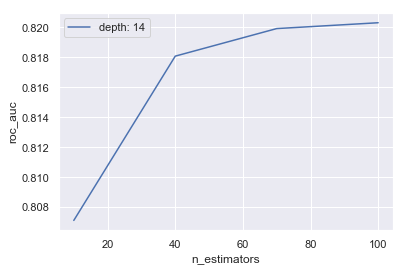

In [138]:
# plot grid search results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
print(means)
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.savefig('n_estimators_vs_max_depth.png')

In [51]:
rf.fit(x_train, y_train)
print(rf.feature_importances_)

C:\Users\DanTang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[7.71569973e-03 9.97019497e-03 6.27779226e-03 7.74327502e-03
 5.11209305e-03 6.69962795e-03 4.31089032e-03 4.66205935e-03
 9.02868547e-03 4.20425925e-03 5.75817109e-03 3.39224257e-03
 3.76566579e-03 1.35104805e-03 1.28329776e-03 0.00000000e+00
 2.03162295e-03 1.48836416e-03 1.20561529e-03 1.01083402e-03
 3.56610949e-03 3.60298164e-03 3.88657570e-03 9.36784537e-03
 8.18365032e-03 4.59263242e-03 9.65492901e-03 1.10191940e-02
 8.95369817e-03 9.58125401e-03 9.95892253e-03 8.91716652e-03
 1.02345806e-02 9.53248354e-03 6.42102282e-03 9.57121585e-03
 7.59460399e-03 7.38444047e-03 9.73824354e-03 1.00672349e-02
 9.58021721e-03 8.92274504e-03 9.68081968e-03 8.66752854e-03
 1.01728340e-02 9.99200174e-03 4.77546367e-03 1.08564268e-02
 7.67764443e-03 8.73210007e-03 9.82259394e-03 9.69152271e-03
 3.04628684e-03 1.22654923e-02 3.58190016e-03 1.20435789e-02
 1.28591670e-02 1.21840912e-02 1.31622368e-02 1.09906240e-02
 1.12824405e-02 1.10260786e-02 8.06055376e-03 9.13514043e-03
 8.64299681e-03 8.680604

In [52]:
# unique, counts = np.unique(rf.feature_importances_, return_counts=True)
# dict(zip(unique[unique>0.], counts))
# sum(rf.feature_importances_)

0.9999999999999998

### Lift

In [42]:
lift = dict()

In [43]:
def lift_table(data, auc, method):
    df_pred = pd.DataFrame(y_test, columns=["y_test"]).join(pd.DataFrame(data, columns=["prediction"]))
    df_pred = df_pred.sort_values("prediction", ascending=False).reset_index(drop=True)

    cnt_p = sum(df_pred["y_test"])
    cnt = len(df_pred)
    cnt_n = cnt - cnt_p
    p_pct = cnt_p/cnt
    decile = round(cnt/10)

    df_lift = pd.DataFrame(index=range(0,10), columns=["decile","counts of response","total counts","counts of non-response","response rate","cum sale rate","cum % of response","cum % of non-response","K-S","Inc. lift","cum lift"])

    for i in range(10):
        if i < (10-1):
            cnt_p_d = df_lift["counts of response"][i] = sum(df_pred["y_test"][i*decile:(i+1)*decile])
            df_lift["total counts"][i] = decile
            cnt_n_d = df_lift["counts of non-response"][i] = decile - cnt_p_d
            df_lift["response rate"][i] = cnt_p_d/decile
            cum_p = df_lift["cum sale rate"][i] = sum(df_pred["y_test"][0:(i+1)*decile])/((i+1)*decile)
            cum_p_pct = df_lift["cum % of response"][i] = cum_p*(i+1)*decile/cnt_p
            cum_n_pct = df_lift["cum % of non-response"][i] = (1-cum_p)*(i+1)*decile/cnt_n


        else:
            cnt_p_d = df_lift["counts of response"][i] = sum(df_pred["y_test"][i*decile:cnt])
            df_lift["total counts"][i] = cnt - i*decile
            cnt_n_d = df_lift["counts of non-response"][i] = cnt - i*decile - cnt_p_d
            df_lift["response rate"][i] = cnt_p_d/(cnt-i*decile)
            cum_p = df_lift["cum sale rate"][i] = sum(df_pred["y_test"][0:cnt])/(cnt)
            cum_p_pct = df_lift["cum % of response"][i] = cum_p*cnt/cnt_p
            cum_n_pct = df_lift["cum % of non-response"][i] = (1-cum_p)*cnt/cnt_n

    df_lift["decile"] = range(1, 11, 1)
    df_lift["K-S"] = df_lift["cum % of response"] - df_lift["cum % of non-response"]
    df_lift["Inc. lift"] = df_lift["response rate"]/p_pct
    df_lift["cum lift"] = df_lift["cum sale rate"]/df_lift["cum sale rate"][9]

    lift[method] = df_lift
    
    print(("%s" % method).upper())
    display(df_lift)
    print("response = ", cnt_p)
    print("non-response = ", cnt_n)
    print("total = ", cnt)
    print("response rate = ", p_pct)
    print("AUC = ", auc)
    print("-"*80)
    print()

In [51]:
lift_table(y_pred_grd, auc_grd, grd) # to show all detailed parameters, just remove ""
lift_table(y_pred_rf, auc_rf, rf)
lift_table(y_pred_lgb, auc_lgb, lgb)
lift_table(y_pred_lr, auc_lr, lr)

GRADIENTBOOSTINGCLASSIFIER(CRITERION='FRIEDMAN_MSE', INIT=NONE,
              LEARNING_RATE=0.1, LOSS='DEVIANCE', MAX_DEPTH=10,
              MAX_FEATURES=NONE, MAX_LEAF_NODES=NONE,
              MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
              MIN_SAMPLES_LEAF=1, MIN_SAMPLES_SPLIT=2,
              MIN_WEIGHT_FRACTION_LEAF=0.0, N_ESTIMATORS=40,
              N_ITER_NO_CHANGE=NONE, PRESORT='AUTO', RANDOM_STATE=110,
              SUBSAMPLE=1.0, TOL=0.0001, VALIDATION_FRACTION=0.1,
              VERBOSE=0, WARM_START=FALSE)


,decile,counts of response,total counts,counts of non-response,response rate,cum sale rate,cum % of response,cum % of non-response,K-S,Inc. lift,cum lift
0,1,2418,2825,407,0.855929,0.855929,0.215029,0.0239313,0.191098,2.15044,2.15044
1,2,2080,2825,745,0.736283,0.796106,0.4,0.0677368,0.332263,1.84984,2.00014
2,3,1768,2825,1057,0.625841,0.739351,0.557225,0.129888,0.427338,1.57237,1.85755
3,4,1393,2825,1432,0.493097,0.677788,0.681103,0.214088,0.467014,1.23886,1.70288
4,5,1073,2825,1752,0.379823,0.618195,0.776523,0.317105,0.459418,0.954269,1.55316
5,6,794,2825,2031,0.281062,0.562006,0.847132,0.436526,0.410606,0.706142,1.41199
6,7,655,2825,2170,0.231858,0.514842,0.90538,0.564121,0.34126,0.582522,1.29349
7,8,476,2825,2349,0.168496,0.471549,0.94771,0.70224,0.24547,0.423329,1.18472
8,9,373,2825,2452,0.132035,0.433825,0.98088,0.846416,0.134464,0.331726,1.08994
9,10,215,2827,2612,0.0760524,0.398025,1,1,0,0.191074,1


response =  11245
non-response =  17007
total =  28252
response rate =  0.39802491858983435
AUC =  0.8039352456628444
--------------------------------------------------------------------------------

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CLASS_WEIGHT=NONE, CRITERION='GINI',
            MAX_DEPTH=10, MAX_FEATURES='AUTO', MAX_LEAF_NODES=NONE,
            MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
            MIN_SAMPLES_LEAF=1, MIN_SAMPLES_SPLIT=2,
            MIN_WEIGHT_FRACTION_LEAF=0.0, N_ESTIMATORS=40, N_JOBS=NONE,
            OOB_SCORE=FALSE, RANDOM_STATE=110, VERBOSE=0, WARM_START=FALSE)


,decile,counts of response,total counts,counts of non-response,response rate,cum sale rate,cum % of response,cum % of non-response,K-S,Inc. lift,cum lift
0,1,2494,2825,331,0.882832,0.882832,0.221787,0.0194626,0.202325,2.21803,2.21803
1,2,2217,2825,608,0.784779,0.833805,0.418942,0.0552126,0.363729,1.97168,2.09486
2,3,1710,2825,1115,0.60531,0.75764,0.571009,0.120774,0.450236,1.52078,1.9035
3,4,1413,2825,1412,0.500177,0.693274,0.696665,0.203798,0.492867,1.25665,1.74179
4,5,1083,2825,1742,0.383363,0.631292,0.792975,0.306227,0.486748,0.963163,1.58606
5,6,761,2825,2064,0.269381,0.570973,0.860649,0.427589,0.433061,0.676793,1.43452
6,7,628,2825,2197,0.222301,0.521163,0.916496,0.556771,0.359725,0.55851,1.30937
7,8,468,2825,2357,0.165664,0.476726,0.958115,0.695361,0.262754,0.416214,1.19773
8,9,293,2825,2532,0.103717,0.43528,0.984171,0.844241,0.13993,0.260579,1.0936
9,10,178,2827,2649,0.0629643,0.398025,1,1,0,0.158192,1


response =  11245
non-response =  17007
total =  28252
response rate =  0.39802491858983435
AUC =  0.8221727443435201
--------------------------------------------------------------------------------

LGBMCLASSIFIER(BOOSTING_TYPE='GBDT', CLASS_WEIGHT=NONE, COLSAMPLE_BYTREE=1.0,
        IMPORTANCE_TYPE='SPLIT', LEARNING_RATE=0.1, MAX_DEPTH=10,
        MIN_CHILD_SAMPLES=20, MIN_CHILD_WEIGHT=0.001, MIN_SPLIT_GAIN=0.0,
        N_ESTIMATORS=40, N_JOBS=-1, NUM_LEAVES=31, OBJECTIVE=NONE,
        RANDOM_STATE=110, REG_ALPHA=0.0, REG_LAMBDA=0.0, SILENT=TRUE,
        SUBSAMPLE=1.0, SUBSAMPLE_FOR_BIN=200000, SUBSAMPLE_FREQ=0)


,decile,counts of response,total counts,counts of non-response,response rate,cum sale rate,cum % of response,cum % of non-response,K-S,Inc. lift,cum lift
0,1,2513,2825,312,0.889558,0.889558,0.223477,0.0183454,0.205132,2.23493,2.23493
1,2,2210,2825,615,0.782301,0.835929,0.420009,0.054507,0.365502,1.96546,2.10019
2,3,1753,2825,1072,0.620531,0.76413,0.5759,0.11754,0.458361,1.55903,1.9198
3,4,1429,2825,1396,0.505841,0.699558,0.702979,0.199624,0.503355,1.27088,1.75757
4,5,1028,2825,1797,0.363894,0.632425,0.794398,0.305286,0.489111,0.914249,1.58891
5,6,808,2825,2017,0.286018,0.57469,0.866252,0.423884,0.442367,0.718592,1.44385
6,7,627,2825,2198,0.221947,0.524298,0.92201,0.553125,0.368885,0.557621,1.31725
7,8,425,2825,2400,0.150442,0.477566,0.959804,0.694244,0.265561,0.377973,1.19984
8,9,292,2825,2533,0.103363,0.435988,0.985771,0.843182,0.142589,0.259689,1.09538
9,10,160,2827,2667,0.0565971,0.398025,1,1,0,0.142195,1


response =  11245
non-response =  17007
total =  28252
response rate =  0.39802491858983435
AUC =  0.827435970902364
--------------------------------------------------------------------------------

LOGISTICREGRESSION(C=1.0, CLASS_WEIGHT=NONE, DUAL=FALSE, FIT_INTERCEPT=TRUE,
          INTERCEPT_SCALING=1, MAX_ITER=500, MULTI_CLASS='WARN',
          N_JOBS=NONE, PENALTY='L2', RANDOM_STATE=110, SOLVER='LBFGS',
          TOL=0.0001, VERBOSE=0, WARM_START=FALSE)


,decile,counts of response,total counts,counts of non-response,response rate,cum sale rate,cum % of response,cum % of non-response,K-S,Inc. lift,cum lift
0,1,2504,2825,321,0.886372,0.886372,0.222677,0.0188746,0.203802,2.22693,2.22693
1,2,2200,2825,625,0.778761,0.832566,0.418319,0.0556242,0.362695,1.95656,2.09174
2,3,1779,2825,1046,0.629735,0.764956,0.576523,0.117128,0.459395,1.58215,1.92188
3,4,1370,2825,1455,0.484956,0.694956,0.698355,0.202681,0.495674,1.21841,1.74601
4,5,1077,2825,1748,0.381239,0.632212,0.794131,0.305462,0.488668,0.957827,1.58837
5,6,803,2825,2022,0.284248,0.574218,0.86554,0.424355,0.441186,0.714146,1.44267
6,7,589,2825,2236,0.208496,0.521972,0.917919,0.55583,0.362089,0.523825,1.31141
7,8,421,2825,2404,0.149027,0.475354,0.955358,0.697184,0.258174,0.374415,1.19428
8,9,320,2825,2505,0.113274,0.435123,0.983815,0.844476,0.139339,0.284591,1.09321
9,10,182,2827,2645,0.0643792,0.398025,1,1,0,0.161747,1


response =  11245
non-response =  17007
total =  28252
response rate =  0.39802491858983435
AUC =  0.824681245080394
--------------------------------------------------------------------------------



In [52]:
lift[grd]

,decile,counts of response,total counts,counts of non-response,response rate,cum sale rate,cum % of response,cum % of non-response,K-S,Inc. lift,cum lift
0,1,2418,2825,407,0.855929,0.855929,0.215029,0.0239313,0.191098,2.15044,2.15044
1,2,2080,2825,745,0.736283,0.796106,0.4,0.0677368,0.332263,1.84984,2.00014
2,3,1768,2825,1057,0.625841,0.739351,0.557225,0.129888,0.427338,1.57237,1.85755
3,4,1393,2825,1432,0.493097,0.677788,0.681103,0.214088,0.467014,1.23886,1.70288
4,5,1073,2825,1752,0.379823,0.618195,0.776523,0.317105,0.459418,0.954269,1.55316
5,6,794,2825,2031,0.281062,0.562006,0.847132,0.436526,0.410606,0.706142,1.41199
6,7,655,2825,2170,0.231858,0.514842,0.90538,0.564121,0.34126,0.582522,1.29349
7,8,476,2825,2349,0.168496,0.471549,0.94771,0.70224,0.24547,0.423329,1.18472
8,9,373,2825,2452,0.132035,0.433825,0.98088,0.846416,0.134464,0.331726,1.08994
9,10,215,2827,2612,0.0760524,0.398025,1,1,0,0.191074,1


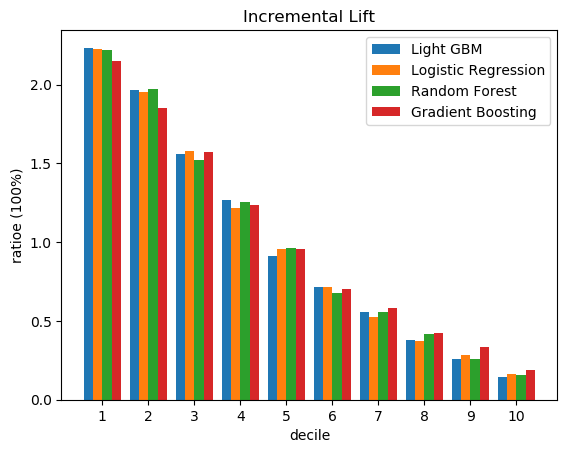

In [57]:
ax = plt.subplot(111)
wdt = 0.2
ax.bar(lift[lgb]["decile"]-3*wdt/2, lift[lgb]["Inc. lift"], width=wdt, label="Light GBM")
ax.bar(lift[lr]["decile"]-wdt/2, lift[lr]["Inc. lift"], width=wdt, label="Logistic Regression")
ax.bar(lift[rf]["decile"]+wdt/2, lift[rf]["Inc. lift"], width=wdt, label="Random Forest")
ax.bar(lift[grd]["decile"]+3*wdt/2, lift[grd]["Inc. lift"], width=wdt, label="Gradient Boosting")
plt.title("Incremental Lift")
plt.xlabel("decile")
plt.ylabel("ratioe (100%)")
plt.xticks(range(1,11))
plt.legend()
plt.show()    

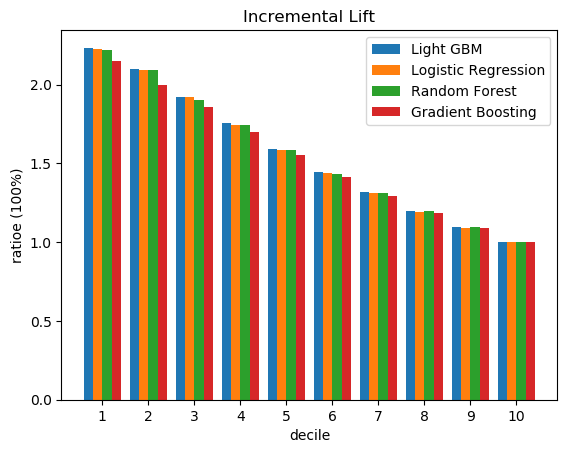

In [58]:
ax = plt.subplot(111)
wdt = 0.2
ax.bar(lift[lgb]["decile"]-3*wdt/2, lift[lgb]["cum lift"], width=wdt, label="Light GBM")
ax.bar(lift[lr]["decile"]-wdt/2, lift[lr]["cum lift"], width=wdt, label="Logistic Regression")
ax.bar(lift[rf]["decile"]+wdt/2, lift[rf]["cum lift"], width=wdt, label="Random Forest")
ax.bar(lift[grd]["decile"]+3*wdt/2, lift[grd]["cum lift"], width=wdt, label="Gradient Boosting")
plt.title("Incremental Lift")
plt.xlabel("decile")
plt.ylabel("ratioe (100%)")
plt.xticks(range(1,11))
plt.legend()
plt.show()    